In [1]:
# Import required libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

2022-08-03 10:32:00.518249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 10:32:00.518290: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# https://fred.stlouisfed.org/series/RSCCASN
df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col='DATE')

In [3]:
# Update column name from RSCCASN to Sales
df.columns = ['Sales']

In [4]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [5]:
# Get test data for last 18 months (1.5 year to cover seasonality)
# Contain monthly data
test_size = 18
test_ind = len(df) - test_size

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [6]:
scaler = MinMaxScaler()

In [7]:
scaler.fit(train)

MinMaxScaler()

In [8]:
scaled_train = scaler.transform(train)

In [9]:
scaled_test = scaler.transform(test)

In [10]:
length = 12
generator = TimeseriesGenerator(
    scaled_train, 
    scaled_train,
    length = length,
    batch_size = 1
)

In [11]:
X,y = generator[0]

In [12]:
n_features = 1

In [13]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2022-08-03 10:32:03.188133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-03 10:32:03.188162: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-03 10:32:03.188185: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kiran-hp): /proc/driver/nvidia/version does not exist
2022-08-03 10:32:03.188660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [17]:
validation_generator = TimeseriesGenerator(
    scaled_test, 
    scaled_test,
    length=length,
    batch_size=1    
)

In [18]:
model.fit_generator(
    generator, 
    epochs=20,
    validation_data=validation_generator,
    callbacks = [early_stop]
)

Epoch 1/20


/tmp/ipykernel_6755/2975621374.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


304/304 [==============================] - 4s 8ms/step - loss: 0.0258 - val_loss: 0.0029
Epoch 2/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0171 - val_loss: 0.0021
Epoch 3/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 0.0024
Epoch 4/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 5/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0034
Epoch 6/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0016 - val_loss: 3.9372e-04
Epoch 7/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0021 - val_loss: 4.4664e-04


In [19]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

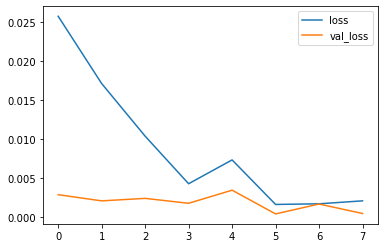

In [20]:
losses.plot()

In [21]:
test_predictions = []

first_eval_batch = scaled_train[-length:] # 12 Records
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)): # 18 Iteration
    
    # Get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # Store prediction
    test_predictions.append(current_pred) 
    
    # Update batch to now append new prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 20ms/step


In [22]:
true_predictions = scaler.inverse_transform(test_predictions)

In [23]:
test['Predictions'] = true_predictions

/tmp/ipykernel_6755/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [24]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,20924.141705
2018-06-01,21589,19969.547614
2018-07-01,21919,20187.768248
2018-08-01,23381,21784.814543
2018-09-01,20260,19579.721385
2018-10-01,21473,20067.470634
2018-11-01,25831,23533.846696
2018-12-01,34706,32912.992338
2019-01-01,16410,16361.247982


<AxesSubplot:xlabel='DATE'>

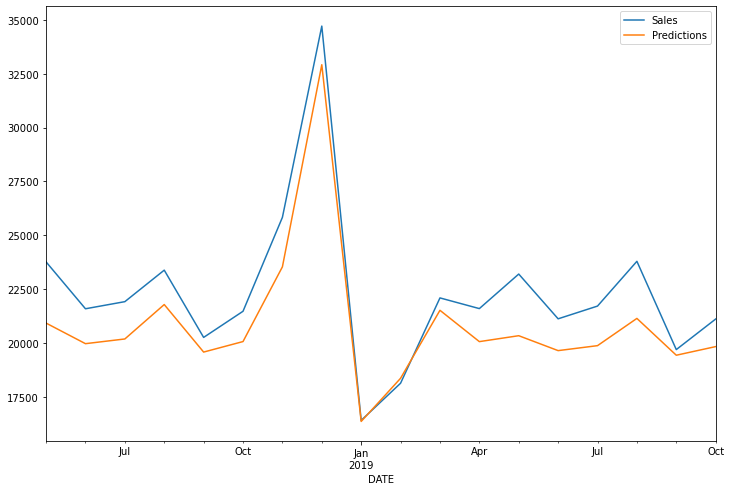

In [25]:
test.plot(figsize=(12,8))

## Create model for full data

In [26]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [27]:
length = 12
generator = TimeseriesGenerator(
    scaled_full_data,
    scaled_full_data,
    length=length,
    batch_size=1
)

In [28]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=8)

Epoch 1/8


/tmp/ipykernel_6755/2176641625.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=8)


322/322 [==============================] - 4s 7ms/step - loss: 0.0268
Epoch 2/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0183
Epoch 3/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0152
Epoch 4/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0072
Epoch 5/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0041
Epoch 6/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0029
Epoch 7/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0018
Epoch 8/8
322/322 [==============================] - 2s 8ms/step - loss: 0.0013


In [29]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # Get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # Store prediction
    forecast.append(current_pred) 
    
    # Update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 28ms/step


In [30]:
forecast = scaler.inverse_transform(forecast)

In [31]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [32]:
forecast

array([[26095.88182402],
       [34573.13027763],
       [18065.8904891 ],
       [19654.68370509],
       [22764.35667181],
       [22413.69521761],
       [23755.72761202],
       [22079.41843176],
       [22606.74207258],
       [24294.75200748],
       [21038.24335337],
       [22210.177279  ]])

In [33]:
forecast_index = pd.date_range(start="2019-11-01", periods=periods, freq="MS") # MS for month start (date)

In [34]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [35]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

<AxesSubplot:>

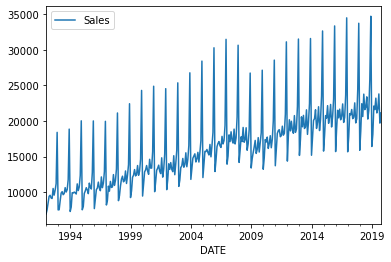

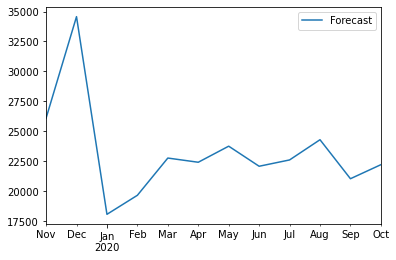

In [36]:
df.plot()
forecast_df.plot()

(576.0, 611.0)

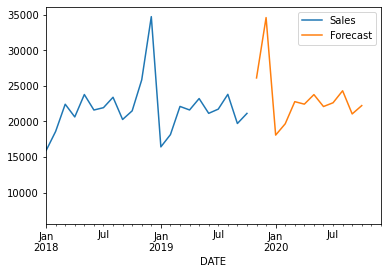

In [37]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-12-01')

# Thank You